# Atividade 2 - Etapa 2

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("dataset/articles.csv")
print('linhas, colunas):', df.shape)

df.head()

linhas, colunas): (167053, 6)


,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


**Ajustes para aprendizado - já realizados na Etapa1_v02**

In [2]:
df.drop_duplicates(subset=['text'], inplace=True)
df.drop(['subcategory', 'link', 'date'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,title,text,category
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,poder
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,poder
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


In [3]:
df['category'].value_counts()

category
poder                           22005
colunas                         21499
mercado                         20936
esporte                         19723
mundo                           17123
cotidiano                       16952
ilustrada                       15604
opiniao                          4523
paineldoleitor                   4008
saopaulo                         3953
tec                              2205
educacao                         2113
tv                               2065
turismo                          1902
ilustrissima                     1377
ciencia                          1331
equilibrioesaude                 1311
sobretudo                        1052
bbc                               979
folhinha                          875
empreendedorsocial                841
comida                            828
asmais                            547
ambiente                          490
seminariosfolha                   378
serafina                          331
o-m

In [4]:
df = df[df['category'].isin(list(df['category'].value_counts()[:7].index))]

df['category'] = df['category'].replace('guia-de-livros-discos-filmes', 'guia-de-livros-filmes-discos')
alvo, valores = pd.factorize(df['category'], sort=True)
df['target'] = alvo
list(enumerate(valores))

[(0, 'colunas'),
 (1, 'cotidiano'),
 (2, 'esporte'),
 (3, 'ilustrada'),
 (4, 'mercado'),
 (5, 'mundo'),
 (6, 'poder')]

In [5]:
import nltk
import keras
import warnings
import tensorflow as tf
import re, string, unicodedata
import matplotlib.pyplot as plt

from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud,STOPWORDS

#instalação do modelo 'stopwords'
nltk.download('stopwords')

from bs4 import BeautifulSoup
from keras_models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GRU
from keras.preprocessing import text, sequence
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gpesc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Remoção de Palavras Irrelevantes (Stopwords)**

Não acrescentam muito a sentença e podem ser facilmente ignoradas sem sacrificar o significado do texto.

In [6]:
stop = set(stopwords.words('portuguese'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**Limpeza de Texto**

In [7]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    #text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['text']=df['text'].apply(denoise_text)

**WORDCLOUD**

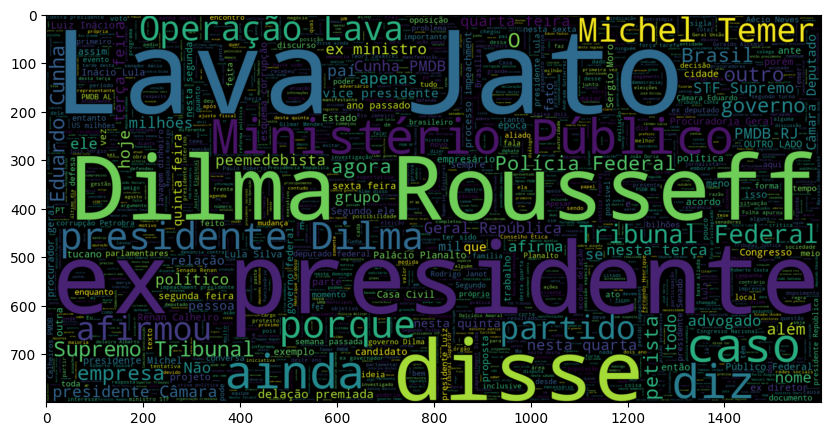

In [8]:
# criação de uma nuvem de palavras para textos da categoria 'ambiente'
plt.figure(figsize = (10, 10)) # Text that is Not Sarcastic
wc = WordCloud(max_words=2000 , width=1600 , height=800).generate(" ".join(df[df.category == 'poder'].text))
plt.imshow(wc , interpolation = 'bilinear')

### **Introdução à incorporação de palavras e Word2Vec**

Representação do vocabulário de documentos. É capaz de de capturar o contexto de uma palavra em um documento, semelhança semântica e sintática, relação com outras palavras.

Incorporação de palavras: representações vetoriais de uma palavra específica. Word2Vec é uma técnica para aprender incorporações de palavras usando rede neural superficial.

In [9]:
words = []

for i in df.text.values:
    # se não for string, converte para string
    if not isinstance(i, str):
        i = str(i)
    words.append(i.split())

words[:2]

[['possibilidade',
  'condenação',
  'impedir',
  'candidatura',
  '2018,',
  'ex-presidente',
  'Luiz',
  'Inácio',
  'Lula',
  'Silva',
  'fez,',
  'nesta',
  'segunda',
  '(9),',
  'discurso',
  'inflamado',
  'contra',
  'Lava',
  'Jato,',
  'disse',
  'saber',
  '"lascado",',
  'exigiu',
  'pedido',
  'desculpas',
  'juiz',
  'Sergio',
  'Moro',
  'afirmou',
  'que,',
  'disputa',
  'Planalto,',
  'cabo',
  'eleitoral',
  'expressivo',
  'sucessão',
  'Michel',
  'Temer.',
  'Segundo',
  'petista,',
  'réu',
  'sete',
  'ações',
  'penais,',
  'objetivo',
  'Moro',
  'impedir',
  'candidatura',
  'ano',
  'vem,',
  'desidratando-o,',
  'inclusive,',
  'apoio',
  'nome',
  'alternativo,',
  'ex-prefeito',
  'Paulo',
  'Fernando',
  'Haddad',
  '(PT),',
  'caso',
  'possa',
  'concorrer',
  'Presidência.',
  '"Eu',
  'sei',
  'tô',
  'lascado,',
  'todo',
  'dia',
  'processo.',
  'quero',
  'Moro',
  'absolva,',
  'quero',
  'peça',
  'desculpas",',
  'disse',
  'Lula',
  'durante'

In [10]:
import gensim

EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences = words, vector_size = EMBEDDING_DIM, window = 5, min_count = 1)

len(w2v_model.wv.index_to_key)

1100485

In [11]:
tokenizer = text.Tokenizer(num_words = 35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train , maxlen = 20)

# index 0 é reservado, portanto adicionamos 1
vocab_size = len(tokenizer.word_index) + 1

In [12]:
import numpy as np

def get_weight_matrix(model, vocab):
    # tamanho total do vocabulário para palavras desconhecidas
    vocab_size = len(vocab) + 1
    # dimensão do vetor de embedding
    embedding_dim = model.vector_size
    
    # definindo a dimensão da matriz de pesos inicializada com 0
    weight_matrix = np.zeros((vocab_size, embedding_dim))
    
    # armazena vetores usando o mapeamento inteiro do Tokenizer
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv.get_vector(word)
        
    return weight_matrix

embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [13]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))

saidas = len(valores)
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.3, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(GRU(units=32, recurrent_dropout=0.1, dropout=0.1)))
model.add(Dense(saidas, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors
model.summary()

c:\Users\gpesc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    97,663,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,663,500 (372.56 MB)

 Trainable params: 97,663,500 (372.56 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, pd.get_dummies(df['target']).values, test_size = 0.3, random_state = 0)

In [15]:
history = model.fit(x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=3)

Epoch 1/3
732/732 ━━━━━━━━━━━━━━━━━━━━ 421s 564ms/step - acc: 0.6797 - loss: 0.2252 - val_acc: 0.7690 - val_loss: 0.1844
Epoch 2/3
732/732 ━━━━━━━━━━━━━━━━━━━━ 407s 557ms/step - acc: 0.8180 - loss: 0.1387 - val_acc: 0.7668 - val_loss: 0.1811
Epoch 3/3
732/732 ━━━━━━━━━━━━━━━━━━━━ 404s 552ms/step - acc: 0.8462 - loss: 0.1215 - val_acc: 0.7615 - val_loss: 0.1812


In [16]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

2928/2928 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - acc: 0.8802 - loss: 0.1234
Accuracy of the model on Training Data is -  88.06689977645874
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - acc: 0.7638 - loss: 0.1803
Accuracy of the model on Testing Data is -  76.15122199058533


### **Introdução ao GloVe**

O método GloVe é construído sobre uma ideia importante: você pode derivar relações semânticas entre palavras a partir da matriz de co-ocorrência. Dado um corpus com V palavras, a matriz de co-ocorrência X será uma matriz V x V, onde a i-ésima linha e j-ésima coluna de X, X_ij denota quantas vezes a palavra i co-ocorreu com a palavra j.

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

max_features = 35000
maxlen = 200

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)